# HMA1 Class

In this guide we will go through a series of steps that will let you discover
functionalities of the `HMA1` class.

## What is HMA1?

The `sdv.relational.HMA1` class implements what is called a _Hierarchical Modeling
Algorithm_ which is an algorithm that allows to recursively walk through a relational
dataset and apply tabular models across all the tables in a way that lets the models
learn how all the fields from all the tables are related.

Let's now discover how to use the `HMA1` class.

## Quick Usage

We will start by loading and exploring one of our demo datasets.

In [1]:
# Setup logging and warnings - change ERROR to INFO for increased verbosity
import logging
logging.basicConfig(level=logging.ERROR)
logging.getLogger().setLevel(level=logging.ERROR)
logging.getLogger('sdv').setLevel(level=logging.ERROR)

import warnings
warnings.simplefilter("ignore")

In [2]:
from sdv import load_demo

metadata, tables = load_demo(metadata=True)

This will return two objects:

1. A `Metadata` object with all the information that **SDV** needs to know about the dataset.

In [3]:
metadata

Metadata
  root_path: .
  tables: ['users', 'sessions', 'transactions']
  relationships:
    sessions.user_id -> users.user_id
    transactions.session_id -> sessions.session_id

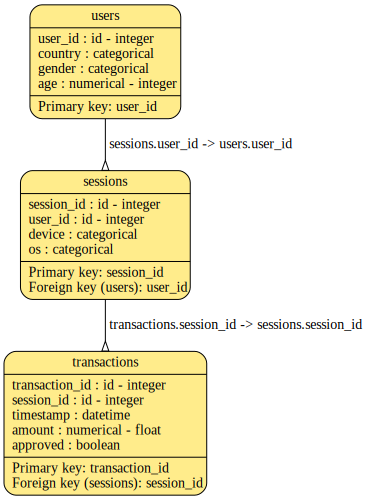

In [4]:
metadata.visualize()

For more details about how to build the `Metadata` for your own dataset, please refer to the
[Working with Metadata](https://sdv-dev.github.io/SDV/tutorials/04_Working_with_Metadata.html)
tutorial.

2. A dictionary containing three `pandas.DataFrames` with the tables described in the
metadata object.

In [5]:
tables

{'users':    user_id country gender  age
 0        0      US      M   34
 1        1      UK      F   23
 2        2      ES   None   44
 3        3      UK      M   22
 4        4      US      F   54
 5        5      DE      M   57
 6        6      BG      F   45
 7        7      ES   None   41
 8        8      FR      F   23
 9        9      UK   None   30,
 'sessions':    session_id  user_id  device       os
 0           0        0  mobile  android
 1           1        1  tablet      ios
 2           2        1  tablet  android
 3           3        2  mobile  android
 4           4        4  mobile      ios
 5           5        5  mobile  android
 6           6        6  mobile      ios
 7           7        6  tablet      ios
 8           8        6  mobile      ios
 9           9        8  tablet      ios,
 'transactions':    transaction_id  session_id           timestamp  amount  approved
 0               0           0 2019-01-01 12:34:32   100.0      True
 1               1  

Let us now use the `HMA1` class to learn this data to be ready to sample synthetic data about
new users.
In order to do this you will need to:

- Import the `sdv.relational.HMA1` class and create an instance of it passing
  the `metadata` that we just loaded.
- Call its `fit` method passing the `tables` dict.

In [6]:
from sdv.relational import HMA1

model = HMA1(metadata)
model.fit(tables)

<div class="alert alert-info">

**NOTE**

During the previous steps SDV walked through all the tables in the dataset following the
relationships specified by the metadata, learned each table using a `GaussianCopula` model
and then augmented the parent tables using the Copulas parameters before learning them. By
doing this, each copula model was able to learn how the child table rows were related to
their parent tables.

</div>

### Generate synthetic data from the model

Once the training process has finished you are ready to generate new synthetic data by calling the `sample_all` method from your model.

In [7]:
new_data = model.sample()

This will return a dictionary of tables identical to the one which the model was fitted on, but
filled with new data which resembles the original one.

In [8]:
new_data

{'users':    user_id country gender  age
 0        0      DE    NaN   35
 1        1      DE      F   25
 2        2      BG      F   51
 3        3      DE      M   38
 4        4      DE      M   23
 5        5      DE      F   26
 6        6      BG      F   27
 7        7      DE      F   43
 8        8      FR      F   34
 9        9      FR      F   31,
 'sessions':     session_id  user_id  device       os
 0            0        1  mobile  android
 1            1        2  mobile  android
 2            2        2  mobile  android
 3            3        3  mobile  android
 4            4        5  tablet  android
 5            5        6  mobile  android
 6            6        7  mobile  android
 7            7        7  mobile  android
 8            8        8  mobile      ios
 9            9        8  mobile      ios
 10          10        9  tablet      ios,
 'transactions':     transaction_id  session_id                     timestamp        amount  \
 0                0       

### Save and Load the model

In many scenarios it will be convenient to generate synthetic versions of your data
directly in systems that do not have access to the original data source. For example,
if you may want to generate testing data on the fly inside a testing environment that
does not have access to your production database. In these scenarios, fitting the
model with real data every time that you need to generate new data is feasible, so you
will need to fit a model in your production environment, save the fitted model into a
file, send this file to the testing environment and then load it there to be able to
`sample` from it.

Let's see how this process works.

#### Save and share the model

Once you have fitted the model, all you need to do is call its `save` method passing the
name of the file in which you want to save the model. Note that the extension of the filename
is not relevant, but we will be using the `.pkl` extension to highlight that the serialization
protocol used is [pickle](https://docs.python.org/3/library/pickle.html).

In [9]:
model.save('my_model.pkl')

This will have created a file called `my_model.pkl` in the same directory in which you are
running SDV.

<div class="alert alert-info">

**IMPORTANT**
    
If you inspect the generated file you will notice that its size is much smaller
than the size of the data that you used to generate it. This is because the serialized model
contains **no information about the original data**, other than the parameters it needs to
generate synthetic versions of it. This means that you can safely share this `my_model.pkl`
file without the risc of disclosing any of your real data!
    
</div>

#### Load the model and generate new data

The file you just generated can be send over to the system where the synthetic data will be
generated. Once it is there, you can load it using the `HMA1.load` method, and
then you are ready to sample new data from the loaded instance:

In [10]:
loaded = HMA1.load('my_model.pkl')
new_data = loaded.sample()
new_data.keys()

dict_keys(['users', 'sessions', 'transactions'])

<div class="alert alert-warning">
    
**WARNING**
    
Notice that the system where the model is loaded needs to also have `sdv` installed,
otherwise it will not be able to load the model and use it.
    
</div>

### How to control the number of rows?

In the steps above we did not tell the model at any moment how many rows we
wanted to sample, so it produced as many rows as there were in the original
dataset.

If you want to produce a different number of rows you can pass it as the
`num_rows` argument and it will produce the indicated number of rows:

In [11]:
new_data = model.sample(num_rows=5)
new_data

{'users':    user_id country gender  age
 0       10      DE    NaN   44
 1       11      DE      M   42
 2       12      FR      F   43
 3       13      FR      F   10
 4       14      DE      M   42,
 'sessions':    session_id  user_id  device       os
 0          11       10  mobile  android
 1          12       12  mobile      ios
 2          13       12  mobile      ios
 3          14       14  mobile  android,
 'transactions':    transaction_id  session_id                     timestamp      amount  \
 0              15          11 2019-01-08 19:21:54.578148864   95.975105   
 1              16          14 2019-01-07 21:24:39.408207104  126.121489   
 2              17          14 2019-01-07 21:24:39.408207104  126.118029   
 
    approved  
 0      True  
 1      True  
 2      True  }

<div class="alert alert-info">

**NOTE**

Notice that the root table `users` has the indicated number of rows but
    some of the other tables do not. This is because the number of rows
    from the child tables is sampled based on the values form the parent
    table, which means that only the root table of the dataset is affected
    by the passed `num_rows` argument.

</div>

### Can I sample a subset of the tables?

In some occasions you will not be interested in generating rows for the entire dataset
and would rather generate data for only one table and its children.

To do this you can simply pass the name of table that you want to sample.

For example, pass the name `sessions` to the `sample` method, the model will only generate
data for the `sessions` table and its child table, `transactions`.

In [12]:
model.sample('sessions', num_rows=5)

{'sessions':    session_id  user_id  device       os
 0          15       19  tablet      ios
 1          16       19  mobile      ios
 2          17       18  tablet      ios
 3          18       19  tablet      ios
 4          19       18  mobile  android,
 'transactions':    transaction_id  session_id                     timestamp     amount  \
 0              18          15 2019-01-16 08:39:29.213854976  83.074066   
 1              19          16 2019-01-09 08:21:16.262817280  87.479030   
 2              20          17 2019-01-23 23:47:08.156482048  82.408671   
 3              21          18 2019-01-12 01:28:30.371112704  67.819870   
 
   approved  
 0      NaN  
 1     True  
 2     True  
 3      NaN  }

If you want to further restrict the sampling process to only one table and
also skip its child tables, you can add the argument `sample_children=False`.

For example, you can sample data from the table `users` only without producing
any rows for the tables `sessions` and `transactions`.

In [13]:
model.sample('users', num_rows=5, sample_children=False)

,user_id,country,gender,age
0,20,DE,NaN,49
1,21,BG,M,40
2,22,DE,F,49
3,23,DE,M,35
4,24,BG,F,49


<div class="alert alert-info">

**NOTE**

In this case, since we are only producing a single table, the output is
    given directly as a `pandas.DataFrame` instead of a dictionary.

</div>